In [4]:
import torch
import math

from kernels import divergence_free_se_kernel, block_diagonal_se_kernel

from visualise import visualise_v_stream, visualise_v_quiver
from dfNN import dfNN_for_vmap, PINN_backbone
from simulate import simulate_convergence, simulate_branching, simulate_ridge, simulate_merge, simulate_deflection
from metrics import compute_RMSE, compute_MAE

import torch
import torch.nn as nn
from torch.func import vmap, jacfwd
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

%load_ext autoreload
%autoreload 2

In [59]:
x_train = torch.load("data/sim_data/x_train_lines_discretised.pt").float()
y_train = simulate_convergence(x_train)

# small data
print(f"The shape of the training inputs is {x_train.shape}.")
print(f"The shape of the training observations is {y_train.shape}.")
print()
print(f"The dtype of the training inputs is {x_train.dtype}.")

The shape of the training inputs is torch.Size([196, 2]).
The shape of the training observations is torch.Size([196, 2]).

The dtype of the training inputs is torch.float32.


In [60]:
# Smaller N because of the computational cost
# Generate rather dense grid for eval
side = torch.linspace(start = 0., end = 3., steps = 10)
XX, YY = torch.meshgrid(side, side, indexing = "xy")
x_test_grid = torch.cat([XX.unsqueeze(-1), YY.unsqueeze(-1)], dim = -1)
x_test = x_test_grid.reshape(-1, 2)

# Retrieve true
y_test = simulate_convergence(x_test)

In [38]:
def GP_predict(
        x_train,
        y_train,
        x_test, 
        hyperparameters,
        mean_func = None,
        divergence_free_bool = True):
    """ 
    Predicts the mean and covariance of the test data given the training data and hyperparameters

    Args:
        x_train (torch.Size([n_train, 2])): x1 and x2 coordinates
        y_train (torch.Size([n_train, 2])): u and v, might be noisy
        x_test (torch.Size([n_test, 2])): x1 and x2 coordinates
        hyperparameters (list): varying length depending on kernel
        mean_func (function, optional): mean function. Defaults to None. Inputs torch.Size([n_test, 2]) and returns torch.Size([n_test, 2] too
        divergence_free_bool (bool, optional): _description_. Defaults to True.

    Returns:
        predictive_mean (torch.Size([n_test, 2])):
        predictive_covariance (torch.Size([n_test, n_test])):
        lml (torch.Size([1])): (positive) log marginal likelihood
    """
    
    # Extract first hyperparameter sigma_n: noise - given, not optimised
    sigma_n = hyperparameters[0]
    
    # Extract number of rows (data points) in x_test
    n_test = x_test.shape[0]
    
    kernel_func = divergence_free_se_kernel if divergence_free_bool else block_diagonal_se_kernel

    # default is zero mean
    if mean_func == None:
        mean_y_train = torch.zeros_like(x_train)
        mean_y_test = torch.zeros_like(x_test)
    else:
        # apply model with vmap
        mean_y_train = vmap(mean_func)(x_train)
        mean_y_test = vmap(mean_func)(x_test)

    # Outputs kernel of shape torch.Size([2 * n_train, 2 * n_train])
    K_train_train = kernel_func(
        x_train, 
        x_train, 
        hyperparameters)

    # Add noise to the diagonal
    K_train_train_noisy = K_train_train + torch.eye(K_train_train.shape[0]) * sigma_n**2

    # torch.Size([2 * n_train, 2 * n_test])
    # K_* in Rasmussen is (x_train, X_test)
    K_train_test = kernel_func(
        x_train, 
        x_test,
        hyperparameters)

    # matrix transpose
    # torch.Size([2 * n_test, 2 * n_train])
    K_test_train = K_train_test.mT

    K_test_test = kernel_func(
        x_test,
        x_test,
        hyperparameters)
    
    # Determine L - torch.Size([2 * n_train, 2 * n_train])
    L = torch.linalg.cholesky(K_train_train_noisy, upper = False)
    # L.T \ (L \ y) in one step - torch.Size([2 * n_train, 1])

    # Make y flat by concatenating u and v (both columns) AFTER each other
    # torch.Size([2 x n_train, 1])
    # y_train_flat = torch.cat([y_train[:, 0], y_train[:, 1]]).unsqueeze(-1)
    y_train_minus_mean = y_train - mean_y_train
    y_train_minus_mean_flat = torch.cat([y_train_minus_mean[:, 0], y_train_minus_mean[:, 1]]).unsqueeze(-1)

    # alpha: torch.Size([2 x n_train, 1])
    alpha = torch.cholesky_solve(y_train_minus_mean_flat, L, upper = False)

    # matrix multiplication
    # torch.Size([2 * n_test, 2 * n_train]) * torch.Size([2 * n_train, 1])
    # alpha needs to be changed to datatype double because K is
    # predictive mean now is torch.Size([2 * n_test]) (after squeezing explicit last dimension)
    predictive_mean = torch.matmul(K_test_train, alpha).squeeze()
    # reshape to separate u and v (which were concatenated after each other)
    # ADD test mean 
    predictive_mean = torch.cat([predictive_mean[:n_test].unsqueeze(-1), predictive_mean[n_test:].unsqueeze(-1)], dim = -1) + mean_y_test

    # Step 3: Solve for V = L^-1 * K(X_*, X)
    # K_* is K_train_test
    # L is lower triangular
    v = torch.linalg.solve_triangular(L, K_train_test, upper = False)
    # same as
    # v = torch.linalg.solve(L, K_train_test)
    # torch.matmul(v, v.T) would give the wrong shape
    predictive_covariance = K_test_test - torch.matmul(v.T, v)

    # matmul: torch.Size([1, 10]) * torch.Size([10, 1])
    # 0.5 * y^T * alpha
    # squeeze to remove redundant dimension
    # y_train are noisy data observations
    lml_term1 = - 0.5 * torch.matmul(y_train_minus_mean_flat.T, alpha).squeeze()

    # sum(log(L_ii)))
    lml_term2 = - torch.sum(torch.log(torch.diagonal(L)))

    # Constant term - technically not optimised 
    # n/2 * log(2 * pi)
    lml_term3 = - (y_train.shape[0]/2) * torch.log(torch.tensor(2 * math.pi))

    lml = lml_term1 + lml_term2 + lml_term3

    return predictive_mean, predictive_covariance, lml

In [35]:
dfNN_mean_model = dfNN_for_vmap()

In [ ]:
sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise
sigma_f = torch.tensor([1.8], requires_grad = True) # initialise
l = torch.tensor([0.3, 0.3], requires_grad = True)

# list of 3 tensors
initial_hyperparameters_df = [sigma_n, sigma_f, l]

# lml on the training data
predictive_mean_df, predictive_covar_df, lml_df = GP_predict(
    x_train,
    y_train,
    x_test, 
    initial_hyperparameters_df, # initial hyperparameters
    dfNN_mean_model,
    divergence_free_bool = True)

lml_df

tensor(-62.4944, grad_fn=<AddBackward0>)

# Check

- subset training data: data loss
- for training: need no predictive mean 

# Fix pretrained dfNN as mean function

In [88]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Initialise fresh model
dfNN_pretrained_mean_model = dfNN_for_vmap()
dfNN_pretrained_mean_model.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(dfNN_pretrained_mean_model.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 1000

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        y_pred = vmap(dfNN_pretrained_mean_model)(x_batch)

        # Compute loss (RMSE for same units as data)
        loss = torch.sqrt(criterion(y_pred, y_batch))
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (RMSE): {loss.item():.4f}")


Start Training
Epoch 1/1000, Training Loss (RMSE): 1.7984
Epoch 2/1000, Training Loss (RMSE): 1.2912
Epoch 3/1000, Training Loss (RMSE): 1.3741
Epoch 4/1000, Training Loss (RMSE): 1.4669
Epoch 5/1000, Training Loss (RMSE): 1.9632
Epoch 6/1000, Training Loss (RMSE): 1.2729
Epoch 7/1000, Training Loss (RMSE): 1.5334
Epoch 8/1000, Training Loss (RMSE): 1.7267
Epoch 9/1000, Training Loss (RMSE): 1.3308
Epoch 10/1000, Training Loss (RMSE): 1.5436
Epoch 11/1000, Training Loss (RMSE): 1.2762
Epoch 12/1000, Training Loss (RMSE): 1.3120
Epoch 13/1000, Training Loss (RMSE): 1.1165
Epoch 14/1000, Training Loss (RMSE): 1.5271
Epoch 15/1000, Training Loss (RMSE): 1.5977
Epoch 16/1000, Training Loss (RMSE): 1.5896
Epoch 17/1000, Training Loss (RMSE): 1.7922
Epoch 18/1000, Training Loss (RMSE): 1.3166
Epoch 19/1000, Training Loss (RMSE): 1.4974
Epoch 20/1000, Training Loss (RMSE): 1.6241
Epoch 21/1000, Training Loss (RMSE): 1.6925
Epoch 22/1000, Training Loss (RMSE): 1.4369
Epoch 23/1000, Training L

In [96]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)

# Pre-trained mean model in eval mode
dfNN_pretrained_mean_model.eval()

sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise

sigma_f = torch.nn.Parameter(torch.tensor([1.8]))  # Requires grad by default
l = torch.nn.Parameter(torch.tensor([0.3, 0.3]))

# list of 3 tensors
learnable_hyperparameters = [sigma_f, l]
all_hyperparameters = [sigma_n] + learnable_hyperparameters

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(learnable_hyperparameters, lr = 0.0001, weight_decay = 1e-4)
num_epochs = 200

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

x_test_small = x_test[:2]

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        _, _, lml_batch = GP_predict(
            x_batch,
            y_batch,
            x_test_small, # doesn't matter
            all_hyperparameters, # initial hyperparameters
            dfNN_pretrained_mean_model,
            divergence_free_bool = True)

        loss = - lml_batch
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (NLML, smaller is better): {loss.item():.4f}")


Start Training
Epoch 1/200, Training Loss (NLML, smaller is better): 152.7738
Epoch 2/200, Training Loss (NLML, smaller is better): 166.5142
Epoch 3/200, Training Loss (NLML, smaller is better): 138.9221
Epoch 4/200, Training Loss (NLML, smaller is better): 141.2599
Epoch 5/200, Training Loss (NLML, smaller is better): 154.8191
Epoch 6/200, Training Loss (NLML, smaller is better): 153.3738
Epoch 7/200, Training Loss (NLML, smaller is better): 170.8899
Epoch 8/200, Training Loss (NLML, smaller is better): 171.5898
Epoch 9/200, Training Loss (NLML, smaller is better): 130.7004
Epoch 10/200, Training Loss (NLML, smaller is better): 148.3798
Epoch 11/200, Training Loss (NLML, smaller is better): 157.8594
Epoch 12/200, Training Loss (NLML, smaller is better): 150.0137
Epoch 13/200, Training Loss (NLML, smaller is better): 184.3578
Epoch 14/200, Training Loss (NLML, smaller is better): 161.5858
Epoch 15/200, Training Loss (NLML, smaller is better): 165.1868
Epoch 16/200, Training Loss (NLML

In [97]:
print(all_hyperparameters)

[tensor([0.0500]), Parameter containing:
tensor([1.7612], requires_grad=True), Parameter containing:
tensor([0.3358, 0.3346], requires_grad=True)]


In [98]:
predictive_mean_test, predictive_covariance_test, lml_train = GP_predict(
            x_train,
            y_train,
            x_test, # doesn't matter
            all_hyperparameters, # initial hyperparameters
            dfNN_pretrained_mean_model,
            divergence_free_bool = True)

print(lml_train)

predictive_mean_train, predictive_covariance_train, lml_train = GP_predict(
            x_train,
            y_train,
            x_train, # doesn't matter
            all_hyperparameters, # initial hyperparameters
            dfNN_pretrained_mean_model,
            divergence_free_bool = True)

print(lml_train)

tensor(-23.8036, grad_fn=<AddBackward0>)
tensor(-23.8036, grad_fn=<AddBackward0>)


In [99]:
# Train
dfGP_meandfNN_train_RMSE = compute_RMSE(y_train, predictive_mean_train)
print(f"dfGP mean-dfNN Train RMSE: {dfGP_meandfNN_train_RMSE:.4f}")
dfGP_meandfNN_train_MAE = compute_MAE(y_train , predictive_mean_train)
print(f"dfGP mean-dfNN Train MAE: {dfGP_meandfNN_train_MAE:.4f}")

# Test
print("")
dfGP_meandfNN_test_RMSE = compute_RMSE(y_test, predictive_mean_test)
print(f"dfGP mean-dfNN Test RMSE: {dfGP_meandfNN_test_RMSE:.4f}")
dfGP_meandfNN_test_MAE = compute_MAE(y_test, predictive_mean_test)
print(f"dfGP mean-dfNN Test MAE: {dfGP_meandfNN_test_MAE:.4f}")
# print(f"dfGP mean-dfNN Test Divergence: {PINN_test_div:.4f}")

dfGP mean-dfNN Train RMSE: 0.0667
dfGP mean-dfNN Train MAE: 0.0412

dfGP mean-dfNN Test RMSE: 0.3922
dfGP mean-dfNN Test MAE: 0.2523


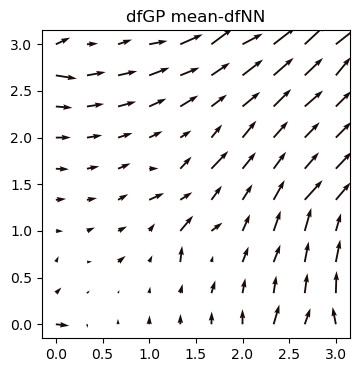

In [100]:
visualise_v_quiver(predictive_mean_test.detach(), x_test, title_string = "dfGP mean-dfNN")

# Joint optimisation

- training NN from scartch

In [106]:
# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 128, shuffle = True)

# Initialise fresh mean model
# dfNN_mean_model = dfNN_for_vmap()
# dfNN_mean_model.train()

sigma_n = torch.tensor([0.05], requires_grad = False) # no optimisation for noise
# sigma_f = torch.tensor([1.8], requires_grad = True) # initialise
# l = torch.tensor([0.3, 0.3], requires_grad = True)

# sigma_f = torch.nn.Parameter(torch.tensor([1.8]))  # Requires grad by default
# l = torch.nn.Parameter(torch.tensor([0.3, 0.3]))

# list of 3 tensors
learnable_hyperparameters = [sigma_f, l]
all_hyperparameters = [sigma_n] + learnable_hyperparameters

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(list(dfNN_mean_model.parameters()) + learnable_hyperparameters, lr = 0.0001, weight_decay = 1e-4)
num_epochs = 200

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

x_test_small = x_test[:2]

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        # 
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        _, _, lml_batch = GP_predict(
            x_batch,
            y_batch,
            x_test_small, # doesn't matter
            all_hyperparameters, # initial hyperparameters
            dfNN_mean_model,
            divergence_free_bool = True)

        # Negative LML
        loss = - lml_batch
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (NLML): {loss.item():.4f}")


Start Training
Epoch 1/200, Training Loss (NLML): 49.2813
Epoch 2/200, Training Loss (NLML): 41.3664
Epoch 3/200, Training Loss (NLML): 53.9514
Epoch 4/200, Training Loss (NLML): 53.2194
Epoch 5/200, Training Loss (NLML): 48.8824
Epoch 6/200, Training Loss (NLML): 43.8631
Epoch 7/200, Training Loss (NLML): 53.4230
Epoch 8/200, Training Loss (NLML): 56.0181
Epoch 9/200, Training Loss (NLML): 57.8847
Epoch 10/200, Training Loss (NLML): 54.3524
Epoch 11/200, Training Loss (NLML): 39.8979
Epoch 12/200, Training Loss (NLML): 56.5963
Epoch 13/200, Training Loss (NLML): 64.0104
Epoch 14/200, Training Loss (NLML): 31.8636
Epoch 15/200, Training Loss (NLML): 45.6219
Epoch 16/200, Training Loss (NLML): 41.5442
Epoch 17/200, Training Loss (NLML): 58.3729
Epoch 18/200, Training Loss (NLML): 59.9774
Epoch 19/200, Training Loss (NLML): 48.9269
Epoch 20/200, Training Loss (NLML): 67.6183
Epoch 21/200, Training Loss (NLML): 51.1679
Epoch 22/200, Training Loss (NLML): 50.9275
Epoch 23/200, Training Lo

In [107]:
print(learnable_hyperparameters)
# updates with print(all_hyperparameters)

[Parameter containing:
tensor([1.6824], requires_grad=True), Parameter containing:
tensor([0.4102, 0.4091], requires_grad=True)]


In [108]:
predictive_mean_test, predictive_covariance_test, lml_train = GP_predict(
            x_train,
            y_train,
            x_test, # doesn't matter
            all_hyperparameters, # initial hyperparameters
            dfNN_mean_model,
            divergence_free_bool = True)

print(lml_train)

predictive_mean_train, predictive_covariance_train, lml_train = GP_predict(
            x_train,
            y_train,
            x_train, # doesn't matter
            all_hyperparameters, # initial hyperparameters
            dfNN_mean_model,
            divergence_free_bool = True)

print(lml_train)

tensor(497.3557, grad_fn=<AddBackward0>)
tensor(497.3557, grad_fn=<AddBackward0>)


In [112]:
# Train
dfGP_meandfNN_train_RMSE = compute_RMSE(y_train, predictive_mean_train)
print(f"dfGP mean-dfNN Train RMSE: {dfGP_meandfNN_train_RMSE:.4f}")
dfGP_meandfNN_train_MAE = compute_MAE(y_train , predictive_mean_train)
print(f"dfGP mean-dfNN Train MAE: {dfGP_meandfNN_train_MAE:.4f}")

# Test
print("")
dfGP_meandfNN_test_RMSE = compute_RMSE(y_test, predictive_mean_test)
print(f"dfGP mean-dfNN Test RMSE: {dfGP_meandfNN_test_RMSE:.4f}")
dfGP_meandfNN_test_MAE = compute_MAE(y_test, predictive_mean_test)
print(f"dfGP mean-dfNN Test MAE: {dfGP_meandfNN_test_MAE:.4f}")
# print(f"dfGP mean-dfNN Test Divergence: {PINN_test_div:.4f}")

dfGP mean-dfNN Train RMSE: 0.0092
dfGP mean-dfNN Train MAE: 0.0070

dfGP mean-dfNN Test RMSE: 0.8988
dfGP mean-dfNN Test MAE: 0.3907


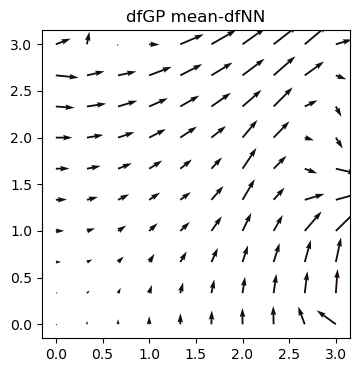

In [111]:
visualise_v_quiver(predictive_mean_test.detach(), x_test, title_string = "dfGP mean-dfNN")

In [93]:
# Functional divergence?
# jacfwd(GP_predict, argnums = 2)(x_train, y_train, y_test, initial_hyperparameters_df, True)